I tried the Multiple Instance Learning [1] method in this project. This method is very useful for weakly annotated data and tiled medical images. Actually, this method is not very suitable for this type of binary classification problem and the sample size is very small (due to the sample size, the model has a superior performance in respect to F1 and ROC AUC Scores). However, I only wanted to try the multiple instance learning. 


<span style="color:#e74c3c;"> <b><i> MAIN GOAL: a HAPPY face detection from a bag that contains all classes </i></b> </span>

<b>If there is at least ONE HAPPY image, the bag has a positive label (1). If all images are not HAPPY in the bag, the bag has a negative label (0).</b>

<br>


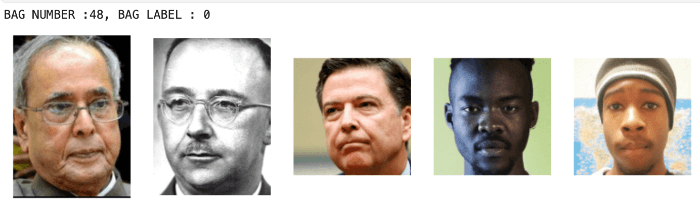

<i> <b>Figure 1:</b> A negative label bag example</i>


<br>

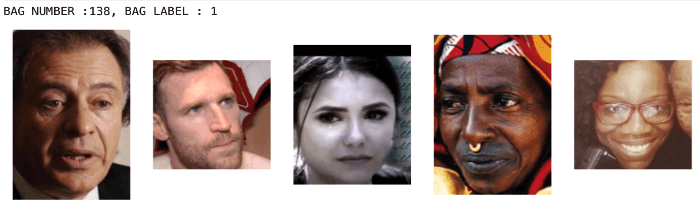

<i> <b>Figure 2:</b> A positive label bag example</i>

<br>


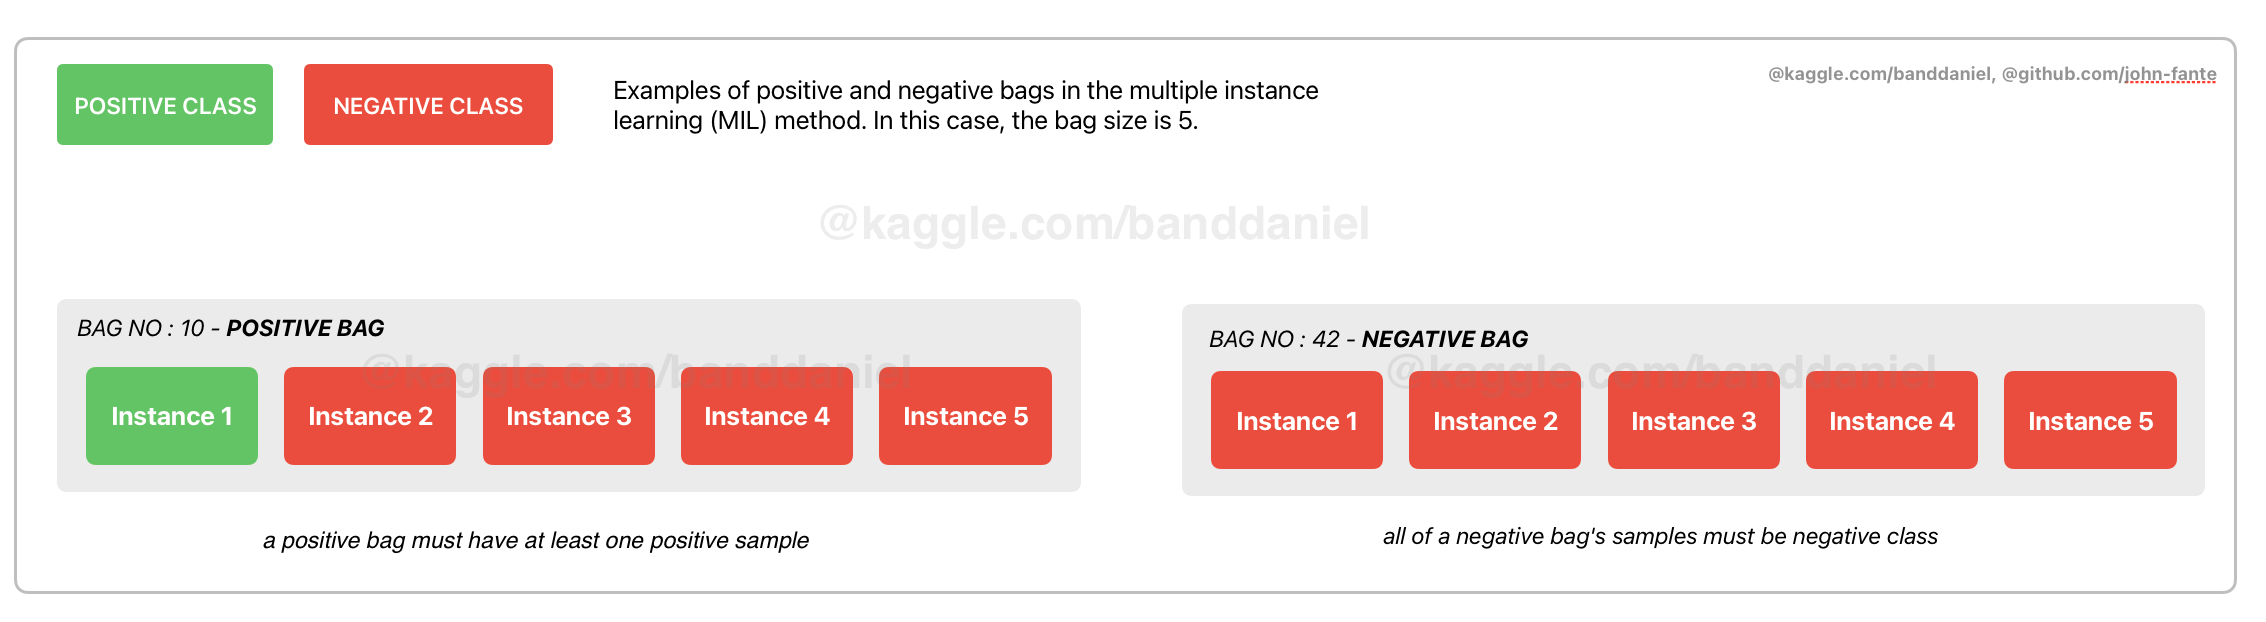

<i> <b>Figure 3:</b> Bags using in the Multiple Instance Learning</i>


<br>

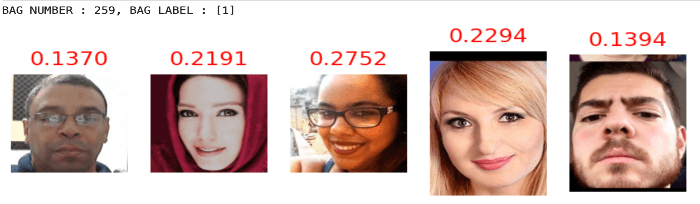

<i> <b>Figure 4:</b> Attention score results of a test bag   </i>



I have used the following methods.

* I used Gated Attention mechanism from the paper[2],
* ResNet101 model for image features,
* Printing bags examples,
* 2 repetitive training steps (like 2-fold cross validation, but in this case we create new train and validation bags for each loop), at the end, averaging all the 2 loops test predictions,
* Rectified and recreated functions in this notebook [3],
* Printing attention scores, 



## My Another Projects
* [Molecule Activity, Deep Multiple Instance Learning](https://www.kaggle.com/code/banddaniel/molecule-activity-deep-multiple-instance-learning)
* [Satellite Image Captioning (ViT, Bi-LSTMs)](https://www.kaggle.com/code/banddaniel/satellite-image-captioning-vit-bi-lstms)
* [Mammals Classification w/Ensemble Deep Learning](https://www.kaggle.com/code/banddaniel/mammals-classification-w-ensemble-deep-learning)
* [Brain Tumor Detection w/Keras YOLO V8](https://www.kaggle.com/code/banddaniel/brain-tumor-detection-w-keras-yolo-v8)


## References
1. https://en.wikipedia.org/wiki/Multiple_instance_learning
2. Ilse, M., Tomczak, J. M., & Welling, M. (2018). Attention-based Deep Multiple Instance Learning (Version 4). arXiv. https://doi.org/10.48550/ARXIV.1802.04712
3. https://keras.io/examples/vision/attention_mil_classification/


In [1]:
# Importing dependencies

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import keras
from tensorflow.keras.layers import Layer, Input, Dense, Dropout, Multiply, concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import *

from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


SEED = 41
IMG_SIZE = 224,224
AUTO = tf.data.AUTOTUNE
FE_BATCH_SIZE = 32 # feature extractor batch size

# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
full_data = pd.read_csv('/kaggle/input/facial-emotion-dataset/facial_emotion_dataset/data.csv')

# label encoding
le = LabelEncoder()
full_data['encoded_label'] = le.fit_transform(full_data['label'])
full_data['new_path'] = '/kaggle/input/facial-emotion-dataset/facial_emotion_dataset/dataset/' + full_data['path']


# a function for dropping bmp images (there are 5 bmp images)
def drop_bmp_image(X):
    if (X[-3:]).lower() == 'bmp':
        return np.NaN
    else:
        return X

full_data['new_path'] = full_data['new_path'].apply(drop_bmp_image) 
full_data = full_data.dropna(ignore_index = True)


# train, valid, test splitting (respectively 80 %, 10 %, 10 %)
train_val_data, test_data = train_test_split(full_data, test_size = 0.1, stratify = full_data['encoded_label'], random_state = SEED)
train_data, valid_data = train_test_split(train_val_data, test_size = 0.1, stratify = train_val_data['encoded_label'], random_state = SEED)

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

print("train images  -> ", train_data.shape[0])
print("valid images  -> ", valid_data.shape[0])
print("test images -> ", test_data.shape[0])

train images  ->  12512
valid images  ->  1391
test images ->  1545


# <span style="color:#e74c3c;"> ResNet101 </span> Feature Extractor

In [3]:
# mirrored strategy
stg = tf.distribute.MirroredStrategy() 

In [4]:
with stg.scope():
    pre_model = ResNet101(include_top=False)
    
    inp = Input(shape = (*IMG_SIZE, 3))
    pre = pre_model(inp)
    X = GlobalAveragePooling2D()(pre)
    X = Dense(256, activation = 'elu', name = 'the_feature_layer')(X)
    X = Dense(64, activation = 'elu')(X)
    out = Dense(6, activation = 'softmax')(X)

    feature_extractor = Model(inputs = inp, outputs = out)
    
    feature_extractor.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                              metrics = ['acc', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_acc')])
    
    my_callbacks = [tf.keras.callbacks.ModelCheckpoint("/kaggle/working/feature_extractor.best_weights.h5",
                                                   monitor="val_loss",mode="min", save_best_only=True, save_weights_only = True )]

171446536/171446536 [==============================] - 1s 0us/step


In [5]:
# Reading -> Resizing -> Normalization
# there are 2 types of images

def img_preprocessing(img, label):
    img = tf.io.read_file(img)
    try:
        img = tf.io.decode_png(img, channels = 3)
        img = tf.image.resize(img, size = (IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    
    except InvalidArgumentError:
        img = tf.io.decode_jpg(img, channels = 3)
        img = tf.image.resize(img, size = (IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        return img, label

In [6]:
# tf.data pipeline and datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_data['new_path'], train_data['encoded_label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(FE_BATCH_SIZE*100)
                 .batch(FE_BATCH_SIZE)
                 .prefetch(AUTO))

# train dataset without shuffling for feature exracting
train_dataset_feature = (train_loader
                         .map(img_preprocessing, num_parallel_calls = AUTO)
                         .batch(FE_BATCH_SIZE)
                         .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['new_path'], valid_data['encoded_label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(FE_BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['new_path'], test_data['encoded_label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(FE_BATCH_SIZE)
                .prefetch(AUTO))

In [7]:
# train feature extactor
hist = feature_extractor.fit(train_dataset, epochs = 8, batch_size = FE_BATCH_SIZE, validation_data = valid_dataset, callbacks = my_callbacks)

Epoch 1/8
391/391 [==============================] - 260s 429ms/step - loss: 0.7770 - acc: 0.6918 - top_3_acc: 0.9538 - val_loss: 2.5930 - val_acc: 0.2430 - val_top_3_acc: 0.7570
Epoch 2/8
391/391 [==============================] - 167s 411ms/step - loss: 0.3717 - acc: 0.8597 - top_3_acc: 0.9933 - val_loss: 0.9161 - val_acc: 0.6528 - val_top_3_acc: 0.9339
Epoch 3/8
391/391 [==============================] - 169s 413ms/step - loss: 0.1936 - acc: 0.9270 - top_3_acc: 0.9982 - val_loss: 0.5741 - val_acc: 0.8052 - val_top_3_acc: 0.9885
Epoch 4/8
391/391 [==============================] - 167s 408ms/step - loss: 0.1002 - acc: 0.9650 - top_3_acc: 0.9996 - val_loss: 0.6957 - val_acc: 0.7944 - val_top_3_acc: 0.9792
Epoch 5/8
391/391 [==============================] - 167s 409ms/step - loss: 0.0530 - acc: 0.9824 - top_3_acc: 0.9998 - val_loss: 0.6635 - val_acc: 0.8138 - val_top_3_acc: 0.9878
Epoch 6/8
391/391 [==============================] - 166s 408ms/step - loss: 0.0488 - acc: 0.9834 - top_3

In [8]:
# saving the feature extactor model
feature_extractor.save('/kaggle/working/feature_extractor_model.h5')

In [9]:
# creating last feature extraction model has 256 features in the output
with stg.scope():
    feature_extr = tf.keras.models.load_model('/kaggle/working/feature_extractor_model.h5')
    feature_extr.load_weights('/kaggle/working/feature_extractor.best_weights.h5')

    feature_model = Model(inputs = feature_extr.input, outputs = feature_extr.get_layer('the_feature_layer').output)
    feature_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048   42658176  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 the_feature_layer (Dense)   (None, 256)               524544    
                                                                 
Total params: 43182720 (164.73 MB)
Trainable params: 43077376 (164.33 MB)
Non-trainable params: 105344 (411.50 KB)
_________________________________________________________________


In [10]:
# creating image features
train_img_features = feature_model.predict(train_dataset_feature)
valid_img_features = feature_model.predict(valid_dataset)
test_img_features = feature_model.predict(test_dataset)


# the feature size
print("the feature size -> ", train_img_features.shape[1])

49/49 [==============================] - 6s 123ms/step
the feature size ->  256


# <span style="color:#e74c3c;"> Creating </span> Bags

In [11]:
# a function for creating bags
# img_features -> image features array
# data_df -> main dataframe
# positive_class -> we chose a class for positive class - in this case 2 for HAPPY class
# bag_size -> bag size 

def create_bags(img_features, data_df, positive_class, bag_size):
    
    bags = []
    bag_labels = []
    bag_img_paths = []
    total_bags = img_features.shape[0] // bag_size
    
    count = 0
    
    for _ in range(total_bags):
        idx = np.random.choice(img_features.shape[0], bag_size, replace=False)
        instances_data = img_features[idx]
        instances_labels = data_df['encoded_label'][idx].values
        instances_paths = data_df['new_path'][idx].values

        bag_label = 0

        if positive_class in instances_labels:
            bag_label = 1
            count += 1


        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))
        bag_img_paths.append(instances_paths)


    print(f"Positive bags: {count}")
    print(f"Negative bags: {total_bags - count}")
    print("-"*20)


    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels), bag_img_paths)

# <span style="color:#e74c3c;"> Creating </span> Test Bags

In [12]:
# positive class 2 for HAPPY images
# if there is at least ONE HAPPY image, the bag has a positive label (1). If all images are others (except happy images) in the bag, the bag has a negative label.

test_bags, test_bags_labels, test_img_paths = create_bags(test_img_features, test_data,  positive_class = 2 ,bag_size = 5)

Positive bags: 225
Negative bags: 84
--------------------


In [13]:
def plot_a_bag(img_paths, bag_labels):
    idx = np.random.choice(len(img_paths), 1, replace=False)[0]
    bag_num = len(img_paths[idx])
    label_bag = bag_labels[idx][0]
    images = img_paths[idx]

    
    print("BAG NUMBER :" + str(idx) + ', BAG LABEL : ' + str(label_bag))

    fig, axs = plt.subplots(1,bag_num, dpi = 150)

    for i in range(bag_num):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].axis('off')

BAG NUMBER :203, BAG LABEL : 1


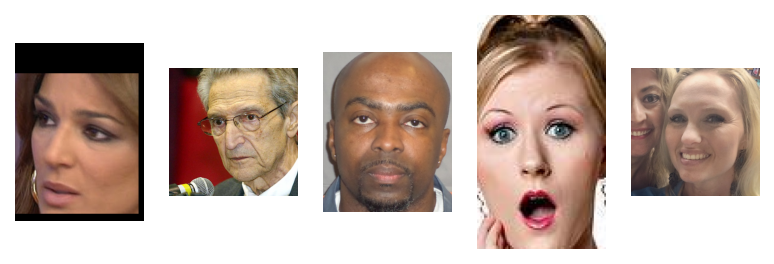

In [14]:
plot_a_bag(test_img_paths, test_bags_labels)

# <span style="color:#e74c3c;"> MIL Gated </span> Attention Layer

In [15]:
class MIL_Attention(Layer):
    def __init__(self, weight_params_dim, kernel_initializer1="glorot_uniform", kernel_initializer2="glorot_uniform",
                 kernel_initializer3="glorot_uniform", kernel_regularizer=None, use_gated=False, **kwargs):

        super(MIL_Attention, self).__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer1 = keras.initializers.get(kernel_initializer1)
        self.kernel_initializer2 = keras.initializers.get(kernel_initializer2)
        self.kernel_initializer3 = keras.initializers.get(kernel_initializer3)

        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer1
        self.w_init = self.kernel_initializer2
        self.u_init = self.kernel_initializer3

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self,input_shape):
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.v_init, name="v",
                                               regularizer=self.v_regularizer, trainable=True)

        self.w_weight_params = self.add_weight(shape=(self.weight_params_dim, 1), initializer=self.w_init, name="w",
                                               regularizer=self.w_regularizer, trainable=True)

        if self.use_gated:
            self.u_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.u_init, name="u",
                                                   regularizer=self.u_regularizer, trainable=True)
        else:
            self.u_weight_params = None
            self.input_built = True

    def call(self, inputs):
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        instances = tf.stack(instances)
        alpha = tf.nn.softmax(instances, axis = 0)
        return [alpha[i] for i in range(alpha.shape[0])]


    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        if self.use_gated:
            instance = instance * tf.math.sigmoid(tf.tensordot(original_instance,self.u_weight_params, axes=1 ))

        return tf.tensordot(instance, self.w_weight_params, axes = 1)
    
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                "weight_params_dim" : self.weight_params_dim,
                "kernel_initializer1" : self.kernel_initializer1,
                "kernel_initializer2" : self.kernel_initializer2,
                "kernel_initializer3" : self.kernel_initializer3,
                "kernel_regularizer" : self.kernel_regularizer,
                "use_gated" : self.use_gated}

In [16]:
# MLP layer with sharing dense layers

class MLP(Layer):
    def __init__(self, dense1_layer, dense2_layer, dense3_layer, dropout_rate, **kwargs):
        super(MLP, self).__init__(**kwargs)
        self.dense1_layer = dense1_layer
        self.dense2_layer = dense2_layer
        self.dense3_layer = dense3_layer
        self.dropout_rate = dropout_rate
        self.drop = Dropout(dropout_rate)
        
    def call(self, inputs):
        X = self.dense1_layer(inputs)
        X = self.drop(X)
        X = self.dense2_layer(X)
        X = self.dense3_layer(X)
        
        return X
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config,
                'dense1_layer' : self.dense1_layer,
                'dense2_layer' : self.dense2_layer,
                'dense3_layer' : self.dense3_layer,
                "dropout_rate" : self.dropout_rate}

# <span style="color:#e74c3c;"> Deep MIL </span> Model

In [17]:
def create_mil_model(dense1_units, dense2_units, dense3_units, weight_params_dim , mlp_dropout_rate = 0.2):

    dense1 = Dense(dense1_units, activation = 'relu')
    dense2 = Dense(dense2_units, activation = 'relu')
    dense3 = Dense(dense3_units, activation = 'relu')
    input_shape = 256

    inp1 = Input(shape =(input_shape))
    ins1 = MLP(dense1, dense2, dense3, mlp_dropout_rate)(inp1)

    inp2 = Input(shape =(input_shape))
    ins2 = MLP(dense1, dense2, dense3, mlp_dropout_rate)(inp2)

    inp3 = Input(shape =(input_shape))
    ins3 = MLP(dense1, dense2, dense3, mlp_dropout_rate)(inp3)
  
    inp4 = Input(shape =(input_shape))
    ins4 = MLP(dense1, dense2, dense3, mlp_dropout_rate)(inp4)

    inp5 = Input(shape =(input_shape))
    ins5 = MLP(dense1, dense2, dense3, mlp_dropout_rate)(inp5)


    attention = MIL_Attention(weight_params_dim = weight_params_dim, kernel_regularizer = keras.regularizers.L2(0.08),
                              use_gated=True, name="attention")([ins1, ins2, ins3, ins4, ins5])

    mult1 = Multiply()([attention[0], ins1])
    mult2 = Multiply()([attention[1], ins2])
    mult3 = Multiply()([attention[2], ins3])
    mult4 = Multiply()([attention[3], ins4])
    mult5 = Multiply()([attention[4], ins5])


    conc = concatenate([mult1, mult2, mult3, mult4, mult5])

    out = Dense(2, activation = 'softmax')(conc)

    model = Model(inputs = [inp1, inp2, inp3, inp4, inp5], outputs = out)
    
    model.compile(optimizer = tf.optimizers.SGD(learning_rate = 0.0005, weight_decay = 0.05, momentum = 0.9),
              loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    
    return model

# <span style="color:#e74c3c;"> Training </span> Loop

In [18]:
# training cross validation loop
def create_train_loop(loop_num, epochs):
    
    test_evals = []
    test_preds = []
    
    for i in range(loop_num):
        print("\n------------------------------  Start Loop No: {0} ------------------------------ ".format(i+1))
        
        # splitting train and validation data then creating bags
        print("\n------ Created Bags (Train, Valid) ------")
        
        train_bags, train_bags_labels, train_img_paths = create_bags(train_img_features, train_data,  positive_class = 2 ,bag_size = 5)
        valid_bags, valid_bags_labels, valid_img_paths = create_bags(valid_img_features, valid_data,  positive_class = 2 ,bag_size = 5)


        # creating the model
        mil_model = create_mil_model(dense1_units = 256, dense2_units = 128, dense3_units = 64, weight_params_dim = 128, mlp_dropout_rate = 0.15)
        
        my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience = 10),
                        tf.keras.callbacks.ModelCheckpoint("/kaggle/working/mil_deep.{0}_loop_weights.h5".format(i+1),
                                                           monitor="val_loss",mode="min", save_best_only=True, verbose=1)]
        
        # training
        hist = mil_model.fit(train_bags, train_bags_labels, validation_data = (valid_bags, valid_bags_labels),
                             batch_size = 1, epochs = epochs, callbacks = my_callbacks ) 
        
        # test evaluation and prediction
        test_eval = mil_model.evaluate(test_bags, test_bags_labels)
        pred = mil_model.predict(test_bags, verbose = 0)
        
        test_evals.append(test_eval)
        test_preds.append(pred)
        
        
    return test_evals, test_preds


# <span style="color:#e74c3c;"> Training </span> 

In [19]:
test_evals, test_preds = create_train_loop(2, epochs = 10)


------------------------------  Start Loop No: 1 ------------------------------ 

------ Created Bags (Train, Valid) ------
Positive bags: 1880
Negative bags: 622
--------------------
Positive bags: 203
Negative bags: 75
--------------------
Epoch 1/10
2502/2502 [==============================] - ETA: 0s - loss: 3.6596 - acc: 0.8541
Epoch 1: val_loss improved from inf to 0.36909, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
2502/2502 [==============================] - 17s 6ms/step - loss: 3.6596 - acc: 0.8541 - val_loss: 0.3691 - val_acc: 0.9460
Epoch 2/10
2496/2502 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.9784
Epoch 2: val_loss improved from 0.36909 to 0.18965, saving model to /kaggle/working/mil_deep.1_loop_weights.h5
2502/2502 [==============================] - 15s 6ms/step - loss: 0.1366 - acc: 0.9784 - val_loss: 0.1897 - val_acc: 0.9496
Epoch 3/10
2497/2502 [============================>.] - ETA: 0s - loss: 0.0667 - acc: 0.9824
Epoch 3: val

# <span style="color:#e74c3c;"> Test </span> Predictions

In [20]:
pred_ = np.mean(test_preds, axis = 0)
pred = np.argmax(pred_, axis = 1)

f1 = f1_score(test_bags_labels, pred)
roc = roc_auc_score(test_bags_labels, pred)

print("F1 Score: {0:.5f}".format(f1))
print("ROC Score: {0:.5f}".format(roc))

F1 Score: 0.96930
ROC Score: 0.93159


# <span style="color:#e74c3c;"> Bags Classification </span> Report

In [21]:
clf = classification_report(test_bags_labels, pred)
print(clf)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        84
           1       0.96      0.98      0.97       225

    accuracy                           0.95       309
   macro avg       0.95      0.93      0.94       309
weighted avg       0.95      0.95      0.95       309



# <span style="color:#e74c3c;"> Bags Confusion </span> Matrix

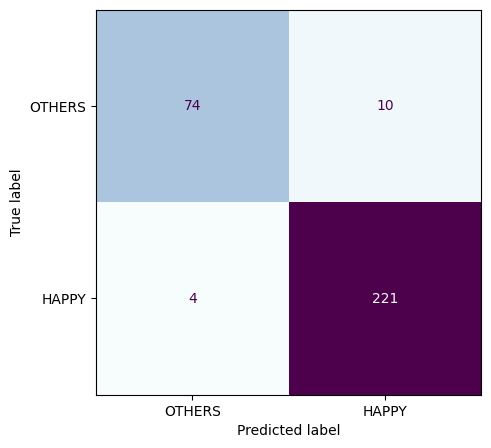

In [22]:
cm = confusion_matrix(test_bags_labels, pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = ["OTHERS", "HAPPY"] )

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

# <span style="color:#e74c3c;"> Attention </span> Performance


In [23]:
def print_attention_score(model, bags, bag_labels, img_paths, SEED = None):
    idx = np.random.default_rng(seed=SEED).permutation(len(bag_labels))[0]
    
    print("BAG NUMBER : " + str(idx) + ", BAG LABEL : " +str(bag_labels[idx]) )
    
    intermediate_model = keras.Model(model.input, model.get_layer("attention").output)
    intermediate_predictions = intermediate_model.predict(bags, verbose = 0)
    attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
    
    images = img_paths[idx]
    attentions = attention_weights[idx]
    fig, axs = plt.subplots(1,img_paths[idx].shape[0], dpi = 150)
    
    for i in range(images.shape[0]):
        img = cv2.imread(images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        att = attentions[i]
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title('{0:.4f}'.format(att), color = 'red')

In [24]:
model = create_mil_model(dense1_units = 256, dense2_units = 128, dense3_units = 64, weight_params_dim = 128, mlp_dropout_rate = 0.15)
model.load_weights('/kaggle/working/mil_deep.2_loop_weights.h5')

BAG NUMBER : 259, BAG LABEL : [0]


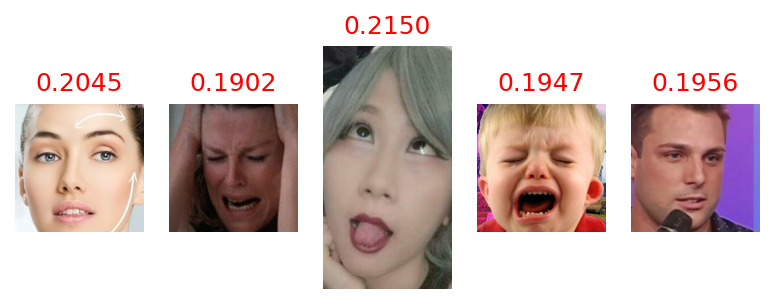

In [25]:
print_attention_score(model, test_bags,  test_bags_labels, test_img_paths, 13)

BAG NUMBER : 117, BAG LABEL : [1]


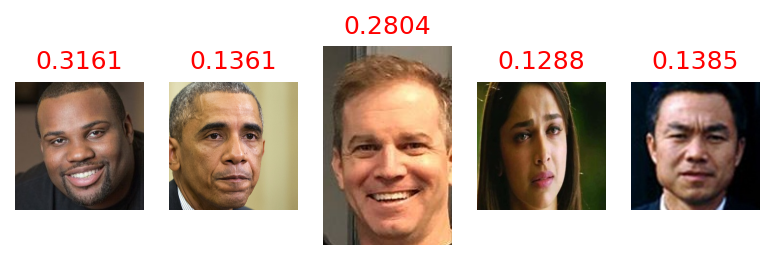

In [26]:
print_attention_score(model, test_bags,  test_bags_labels, test_img_paths, 7)

BAG NUMBER : 173, BAG LABEL : [1]


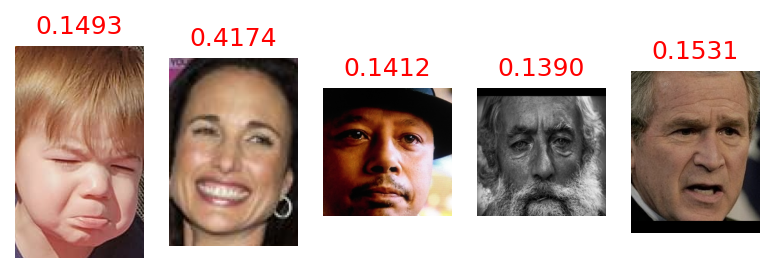

In [27]:
print_attention_score(model, test_bags,  test_bags_labels, test_img_paths, 321)